In [42]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [43]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

batch_size = 128

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [46]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1)
        self.fc_mu = nn.Linear(in_features=64*2*7*7, out_features=2)
        self.fc_logvar = nn.Linear(in_features=64*2*7*7, out_features=2)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=2, out_features=64*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64*2, 7, 7)
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x))
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

def vae_loss(recon_x, x, mu, logvar, beta):
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kldivergence

In [47]:
beta = 1.0
num_epochs = 100
learning_rate = 1e-3

vae = VariationalAutoencoder().to('cuda')
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for batch in train_dataloader:
        x, _ = batch
        x = x.to('cuda')

        # vae reconstruction
        x_pred, latent_mu, latent_logvar = vae(x)
        
        # reconstruction error
        loss = vae_loss(x_pred, x, latent_mu, latent_logvar, beta)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23440.115426
Epoch [2 / 100] average reconstruction error: 20987.991738
Epoch [3 / 100] average reconstruction error: 20456.238146
Epoch [4 / 100] average reconstruction error: 20182.462260
Epoch [5 / 100] average reconstruction error: 20018.248278
Epoch [6 / 100] average reconstruction error: 19899.256959
Epoch [7 / 100] average reconstruction error: 19804.368316
Epoch [8 / 100] average reconstruction error: 19704.027096
Epoch [9 / 100] average reconstruction error: 19643.801868
Epoch [10 / 100] average reconstruction error: 19577.394388
Epoch [11 / 100] average reconstruction error: 19514.888634
Epoch [12 / 100] average reconstruction error: 19467.492631
Epoch [13 / 100] average reconstruction error: 19417.472819
Epoch [14 / 100] average reconstruction error: 19370.390381
Epoch [15 / 100] average reconstruction error: 19334.508206
Epoch [16 / 100] average reconstruction error: 19296.808916
Epoch [17 / 100] average reconstruct

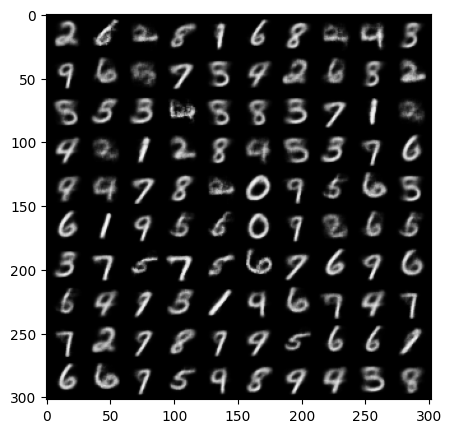

In [50]:
import numpy as np
import matplotlib.pyplot as plt

import torchvision.utils

vae.eval()
with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, 2, device='cuda')

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()
    
    grid = torchvision.utils.make_grid(img_recon.data[:100], 10)
    grid = np.transpose(grid.numpy(), (1, 2, 0))

    fig, ax = plt.subplots(figsize=(5, 5))
    plt.imshow(grid)